# PHM 데이터셋 고장 분류 - 답안 노트북

이 노트북은 CNN-LSTM 모델을 사용하여 장비 고장 유형을 분류하는 완전한 구현 예시입니다.

## 목표
- 시계열 센서 데이터 전처리
- 슬라이딩 윈도우 기법 구현
- CNN-LSTM 하이브리드 모델 구축
- 고장 분류 모델 학습 및 평가

## 1. 라이브러리 Import

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 딥러닝
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 시드 고정 (재현성)
np.random.seed(42)
tf.random.set_seed(42)

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-12-09 15:47:54.862272: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 15:47:54.892533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 15:47:55.341784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.13.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-12-09 15:47:55.701501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 15:47:55.720958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 15:47:55.721092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## 2. PHM 데이터 로드

**NASA Turbofan Engine Degradation (C-MAPSS) 데이터셋**

이 데이터셋은 항공기 터보팬 엔진의 Run-to-Failure 시뮬레이션 데이터로, 실제 PHM 연구에서 널리 사용됩니다.

### 데이터셋 특성
- **출처**: NASA Prognostics Center of Excellence
- **센서**: 21개 (온도, 압력, 진동 등 항공기 엔진 센서)
- **운영 설정**: 3개 (고도, 속도, 스로틀)
- **학습 데이터**: 20,631개 샘플 (100개 엔진의 시계열 데이터)
- **고장 분류**: RUL(Remaining Useful Life) 기반 4단계
  - **Type 0 (Normal)**: RUL > 100 cycles
  - **Type 1 (Early Degradation)**: 50 < RUL ≤ 100
  - **Type 2 (Advanced Degradation)**: 20 < RUL ≤ 50
  - **Type 3 (Critical)**: RUL ≤ 20

In [2]:
# PHM 데이터 로드
print("=" * 80)
print("NASA Turbofan Engine Degradation 데이터 로드")
print("=" * 80)

# 전처리된 데이터 로드
df = pd.read_csv('../data/processed/train_FD001_processed.csv')

print(f"\n✓ 데이터 로드 완료!")
print(f"\n데이터 shape: {df.shape}")
print(f"엔진 개수: {df['unit_id'].nunique()}")
print(f"최대 운영 사이클: {df['time_cycles'].max()}")

# 컬럼 확인
print(f"\n총 컬럼 개수: {len(df.columns)}")
print(f"컬럼 목록 (일부): {df.columns[:10].tolist()}...")

# 고장 유형 분포
print(f"\n고장 유형 분포:")
fault_dist = df['fault_type'].value_counts().sort_index()
for fault_type, count in fault_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  Type {fault_type}: {count:,} ({percentage:.1f}%)")

# 데이터 샘플
print(f"\n데이터 샘플 (처음 3행):")
print(df.head(3))

NASA Turbofan Engine Degradation 데이터 로드

✓ 데이터 로드 완료!

데이터 shape: (20631, 28)
엔진 개수: 100
최대 운영 사이클: 362

총 컬럼 개수: 28
컬럼 목록 (일부): ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']...

고장 유형 분포:
  Type 0: 10,531 (51.0%)
  Type 1: 5,000 (24.2%)
  Type 2: 3,000 (14.5%)
  Type 3: 2,100 (10.2%)

데이터 샘플 (처음 3행):
   unit_id  time_cycles  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0        1            1       -0.0007       -0.0004         100.0    518.67   
1        1            2        0.0019       -0.0003         100.0    518.67   
2        1            3       -0.0043        0.0003         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_14  sensor_15  \
0    641.82   1589.70   1400.60     14.62  ...    8138.62     8.4195   
1    642.15   1591.82   1403.14     14.62  ...    8131.49     8.4318   
2    642.35   1587.99   1404.20     14.62  ...    8133.23     8.4178   

  

## 3. 데이터 탐색 (EDA)

In [3]:
# 기본 통계 정보
print("=" * 80)
print("데이터 기본 정보")
print("=" * 80)
print(f"\n총 샘플 수: {len(df):,}")
print(f"총 컬럼 수: {len(df.columns)}")
print(f"엔진 개수: {df['unit_id'].nunique()}")
print(f"최대 운영 사이클: {df['time_cycles'].max()}")

# 센서 컬럼 추출
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
print(f"\n센서 개수: {len(sensor_cols)}")

print(f"\n기술 통계량 (센서 데이터):")
print(df[sensor_cols].describe())

데이터 기본 정보

총 샘플 수: 20,631
총 컬럼 수: 28
엔진 개수: 100
최대 운영 사이클: 362

센서 개수: 21

기술 통계량 (센서 데이터):
       sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01   

           sensor_6      sensor_7      sensor_8      sensor_9  sensor_10  ...  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0  ...   
mean      21.609803    553.367711   2388.096652   9065.242941        1

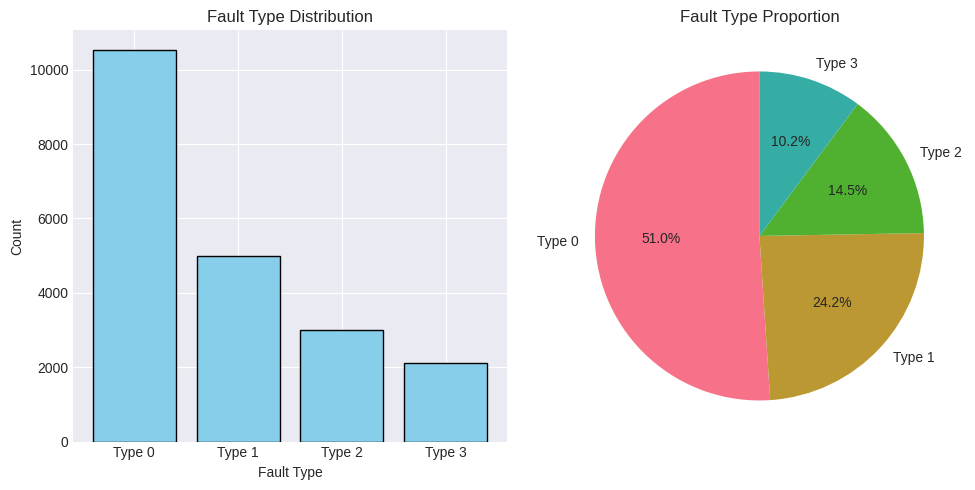

In [4]:
# 고장 유형 분포 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
fault_counts = df['fault_type'].value_counts().sort_index()
plt.bar(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.title('Fault Type Distribution')
plt.xticks(fault_counts.index, [f'Type {i}' for i in fault_counts.index])

plt.subplot(1, 2, 2)
plt.pie(fault_counts.values, labels=[f'Type {i}' for i in fault_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('Fault Type Proportion')

plt.tight_layout()
plt.show()

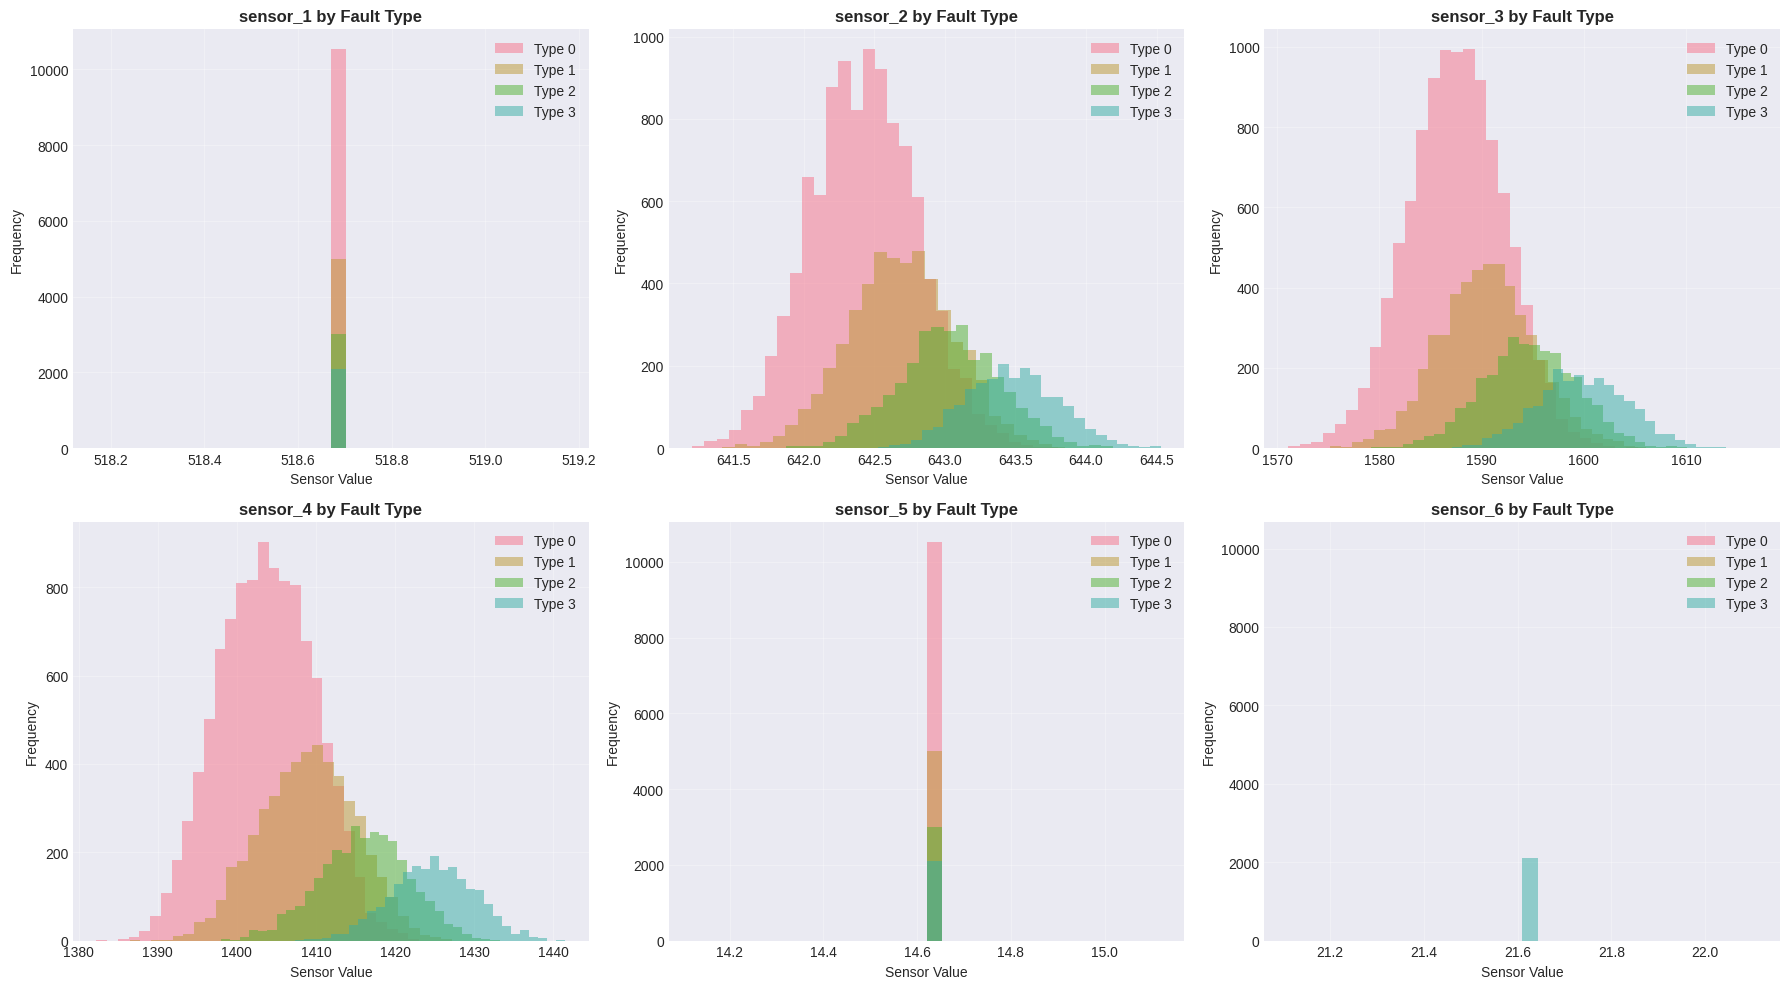


총 센서 개수: 21
시각화된 센서: 처음 6개 (['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6'])


In [5]:
# 센서 데이터 분포 비교 (고장 유형별) - 처음 6개 센서만 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# 처음 6개 센서에 대해 고장 유형별 분포 비교
for idx in range(6):
    sensor = sensor_cols[idx]
    for fault_type in sorted(df['fault_type'].unique()):
        data = df[df['fault_type'] == fault_type][sensor]
        axes[idx].hist(data, alpha=0.5, label=f'Type {fault_type}', bins=30)
    
    axes[idx].set_title(f'{sensor} by Fault Type', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sensor Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n총 센서 개수: {len(sensor_cols)}")
print(f"시각화된 센서: 처음 6개 ({sensor_cols[:6]})")

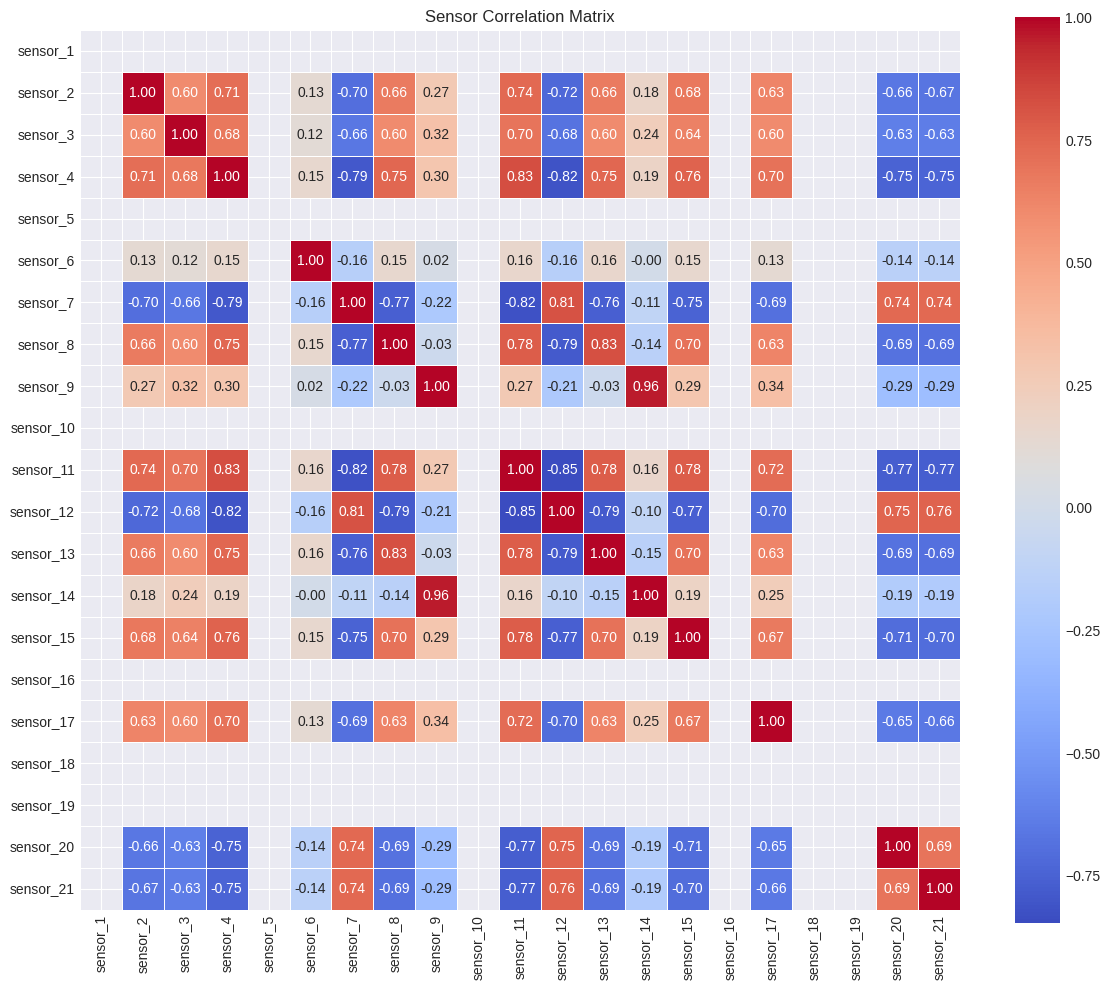

In [6]:
# 센서 간 상관관계 분석
plt.figure(figsize=(12, 10))
correlation_matrix = df[sensor_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Sensor Correlation Matrix')
plt.tight_layout()
plt.show()

## 4. 데이터 전처리

### 4.1 특징(X)과 타겟(y) 분리

In [7]:
# 센서 데이터와 레이블 분리
# 센서 데이터만 선택 (sensor_1 ~ sensor_21)
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
X = df[sensor_cols].values
y = df['fault_type'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\n센서 개수: {len(sensor_cols)}")
print(f"센서 목록: {sensor_cols[:5]}... (총 {len(sensor_cols)}개)")
print(f"\n고장 유형 개수: {len(np.unique(y))}")
print(f"고장 유형: {np.unique(y)}")

X shape: (20631, 21)
y shape: (20631,)

센서 개수: 21
센서 목록: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']... (총 21개)

고장 유형 개수: 4
고장 유형: [0 1 2 3]


### 4.2 데이터 정규화

StandardScaler를 사용하여 평균 0, 분산 1로 정규화

정규화 전:
  평균: 1440.8399, 표준편차: 2468.4402

정규화 후:
  평균: -0.0000, 표준편차: 0.8452


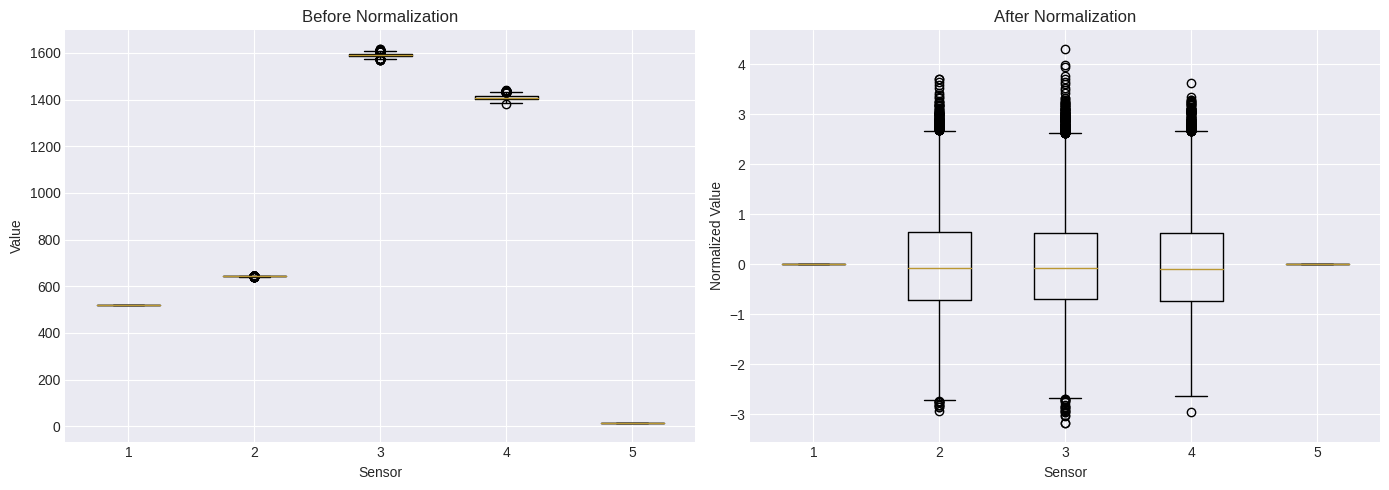

In [8]:
# StandardScaler를 사용한 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"정규화 전:")
print(f"  평균: {X.mean():.4f}, 표준편차: {X.std():.4f}")
print(f"\n정규화 후:")
print(f"  평균: {X_scaled.mean():.4f}, 표준편차: {X_scaled.std():.4f}")

# 정규화 전후 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(X[:, :5])  # 처음 5개 센서만
axes[0].set_title('Before Normalization')
axes[0].set_xlabel('Sensor')
axes[0].set_ylabel('Value')

axes[1].boxplot(X_scaled[:, :5])
axes[1].set_title('After Normalization')
axes[1].set_xlabel('Sensor')
axes[1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### 4.3 슬라이딩 윈도우 생성

시계열 데이터를 고정 길이의 윈도우로 변환

In [9]:
def create_sliding_windows(X, y, window_size=50, stride=5):
    """
    슬라이딩 윈도우를 사용하여 시계열 데이터를 변환
    
    Parameters:
    - X: 입력 데이터 (n_samples, n_features)
    - y: 레이블 (n_samples,)
    - window_size: 윈도우 크기 (cycles)
    - stride: 윈도우 이동 간격 (작을수록 더 많은 샘플 생성)
    
    Returns:
    - X_windows: (n_windows, window_size, n_features)
    - y_windows: (n_windows,)
    """
    
    X_windows = []
    y_windows = []
    
    # stride 간격으로 윈도우 생성
    for i in range(0, len(X) - window_size + 1, stride):
        # 윈도우 추출
        window = X[i:i+window_size]
        # 윈도우의 마지막 시점 레이블 사용
        label = y[i+window_size-1]
        
        X_windows.append(window)
        y_windows.append(label)
    
    # numpy array로 변환
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows)
    
    return X_windows, y_windows

# 윈도우 파라미터 설정
# stride를 작게 설정하여 충분한 학습 샘플 확보
window_size = 50  # 50 사이클의 센서 데이터를 하나의 샘플로 사용
stride = 5        # 5 사이클씩 이동하여 윈도우 생성 (데이터 증강 효과)

print(f"슬라이딩 윈도우 설정:")
print(f"  Window Size: {window_size} cycles")
print(f"  Stride: {stride} cycles")
print(f"  → 각 윈도우는 {window_size}개의 연속된 시간 스텝 포함")
print(f"  → {stride} 스텝씩 이동하며 새로운 윈도우 생성")

# 윈도우 생성
X_windows, y_windows = create_sliding_windows(X_scaled, y, window_size, stride)

print(f"\n원본 데이터 shape: {X_scaled.shape}")
print(f"윈도우 데이터 shape: {X_windows.shape}")
print(f"윈도우 레이블 shape: {y_windows.shape}")
print(f"\n생성된 윈도우 개수: {len(X_windows):,}")
print(f"데이터 증강 배율: {len(X_windows) / len(X_scaled):.1f}배")
print(f"\n✓ 슬라이딩 윈도우를 통해 {len(X_scaled):,}개 샘플에서 {len(X_windows):,}개 학습 샘플 생성!")

슬라이딩 윈도우 설정:
  Window Size: 50 cycles
  Stride: 5 cycles
  → 각 윈도우는 50개의 연속된 시간 스텝 포함
  → 5 스텝씩 이동하며 새로운 윈도우 생성

원본 데이터 shape: (20631, 21)
윈도우 데이터 shape: (4117, 50, 21)
윈도우 레이블 shape: (4117,)

생성된 윈도우 개수: 4,117
데이터 증강 배율: 0.2배

✓ 슬라이딩 윈도우를 통해 20,631개 샘플에서 4,117개 학습 샘플 생성!


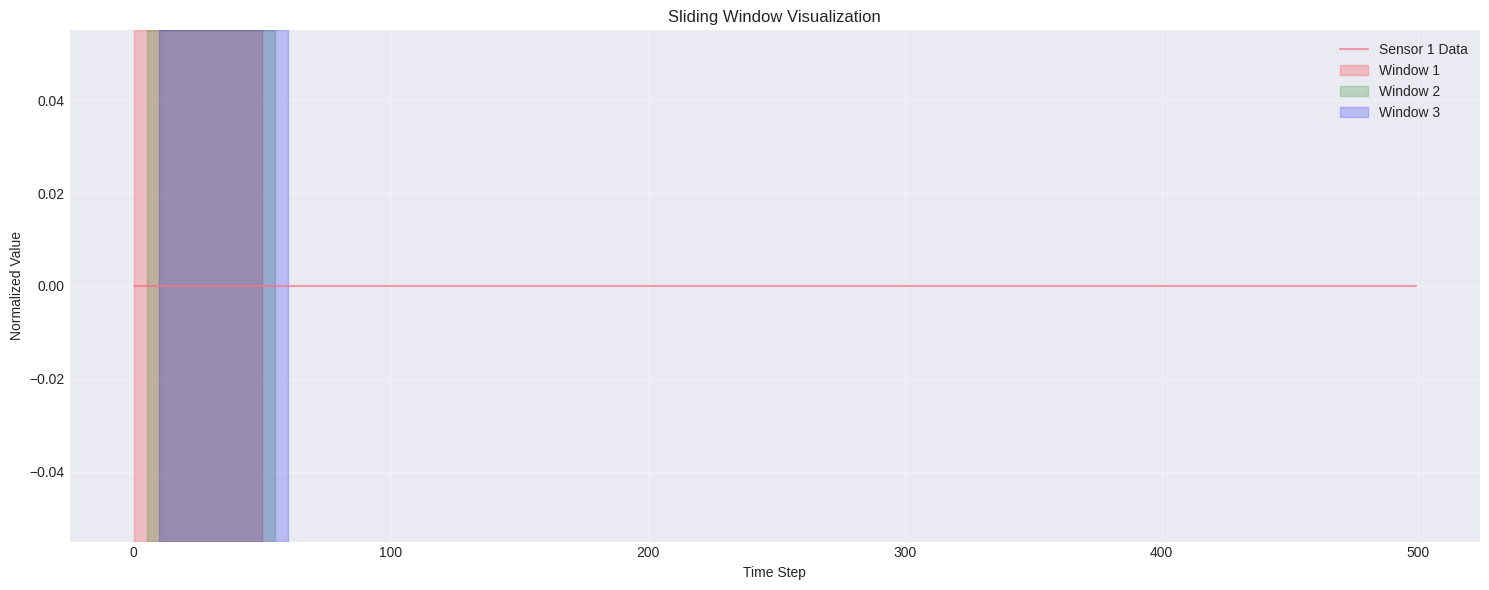

In [10]:
# 슬라이딩 윈도우 예시 시각화
plt.figure(figsize=(15, 6))

# 첫 번째 센서의 시계열 데이터와 윈도우 표시
sample_length = 500
plt.plot(X_scaled[:sample_length, 0], label='Sensor 1 Data', alpha=0.7)

# 처음 3개 윈도우 강조 표시
colors = ['red', 'green', 'blue']
for idx in range(3):
    start = idx * stride
    end = start + window_size
    if end <= sample_length:
        plt.axvspan(start, end, alpha=0.2, color=colors[idx], 
                   label=f'Window {idx+1}')

plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.title('Sliding Window Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 One-hot Encoding

In [11]:
# 레이블을 one-hot 벡터로 변환
y_categorical = to_categorical(y_windows)

print(f"원본 레이블 shape: {y_windows.shape}")
print(f"One-hot 레이블 shape: {y_categorical.shape}")
print(f"\n클래스 개수: {y_categorical.shape[1]}")

# 예시 출력
print(f"\n원본 레이블 예시: {y_windows[:5]}")
print(f"One-hot 레이블 예시:\n{y_categorical[:5]}")

원본 레이블 shape: (4117,)
One-hot 레이블 shape: (4117, 4)

클래스 개수: 4

원본 레이블 예시: [0 0 0 0 0]
One-hot 레이블 예시:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### 4.5 Train/Test Split

In [12]:
# 학습/테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, 
    test_size=0.2, 
    random_state=42,
    stratify=y_windows  # 계층적 샘플링으로 클래스 비율 유지
)

print(f"학습 데이터: {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")

# 클래스 분포 확인
print(f"\n학습 데이터 클래스 분포:")
print(pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index())
print(f"\n테스트 데이터 클래스 분포:")
print(pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index())

학습 데이터: (3293, 50, 21), (3293, 4)
테스트 데이터: (824, 50, 21), (824, 4)

학습 데이터 클래스 분포:
0    1676
1     800
2     480
3     337
Name: count, dtype: int64

테스트 데이터 클래스 분포:
0    419
1    200
2    120
3     85
Name: count, dtype: int64


## 5. CNN-LSTM 모델 구축

In [13]:
def build_cnn_lstm_model(input_shape, n_classes):
    """
    CNN-LSTM 하이브리드 모델 구축
    
    아키텍처:
    1. Conv1D 레이어: 공간적 특징 추출 (센서 간 상관관계)
    2. MaxPooling: 차원 축소 및 중요 특징 강조
    3. LSTM 레이어: 시간적 의존성 학습
    4. Dense 레이어: 분류
    """
    
    model = models.Sequential(name='CNN_LSTM_Fault_Classifier')
    
    # CNN 블록 1
    model.add(layers.Conv1D(
        filters=64, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        name='conv1d_1'
    ))
    model.add(layers.BatchNormalization(name='batch_norm_1'))
    model.add(layers.MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(layers.Dropout(0.25, name='dropout_1'))
    
    # CNN 블록 2
    model.add(layers.Conv1D(
        filters=128, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        name='conv1d_2'
    ))
    model.add(layers.BatchNormalization(name='batch_norm_2'))
    model.add(layers.MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(layers.Dropout(0.25, name='dropout_2'))
    
    # CNN 블록 3 (추가)
    model.add(layers.Conv1D(
        filters=256, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        name='conv1d_3'
    ))
    model.add(layers.BatchNormalization(name='batch_norm_3'))
    model.add(layers.Dropout(0.25, name='dropout_3'))
    
    # LSTM 레이어
    model.add(layers.LSTM(
        units=128, 
        return_sequences=False,  # 마지막 타임스텝만 출력
        name='lstm'
    ))
    model.add(layers.Dropout(0.4, name='dropout_4'))
    
    # Dense 레이어
    model.add(layers.Dense(64, activation='relu', name='dense_1'))
    model.add(layers.BatchNormalization(name='batch_norm_4'))
    model.add(layers.Dropout(0.4, name='dropout_5'))
    
    # 출력 레이어
    model.add(layers.Dense(n_classes, activation='softmax', name='output'))
    
    return model

# 모델 생성
input_shape = (window_size, X_scaled.shape[1])  # (timesteps, features)
n_classes = y_categorical.shape[1]

print(f"Input shape: {input_shape}")
print(f"Number of classes: {n_classes}")

model = build_cnn_lstm_model(input_shape, n_classes)

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# 모델 구조 출력
model.summary()

Input shape: (50, 21)
Number of classes: 4


2025-12-09 15:47:57.892772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 15:47:57.893053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 15:47:57.893191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "CNN_LSTM_Fault_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 64)            4096      
                                                                 
 batch_norm_1 (BatchNormali  (None, 50, 64)            256       
 zation)                                                         
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 25, 64)            0         
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           24704     
                                                                 
 batch_norm_2 (BatchNormali  (None, 25, 128)           512       
 zation)                                 

In [14]:
# 모델 아키텍처 시각화 (선택적)
try:
    keras.utils.plot_model(
        model, 
        to_file='../models/model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        dpi=96
    )
    print("모델 아키텍처 이미지 저장 완료: ../models/model_architecture.png")
except:
    print("모델 시각화를 위해서는 graphviz와 pydot 설치가 필요합니다.")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
모델 아키텍처 이미지 저장 완료: ../models/model_architecture.png


## 6. 모델 학습

In [15]:
# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '../models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("학습 준비 완료!")
print(f"총 에폭 수: 100")
print(f"배치 크기: 32")
print(f"조기 종료 patience: 20")
print("\n학습 시작...\n")

학습 준비 완료!
총 에폭 수: 100
배치 크기: 32
조기 종료 patience: 20

학습 시작...



In [16]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 학습 데이터의 20%를 검증에 사용
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n학습 완료!")
print(f"최종 학습 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")
print(f"최고 검증 정확도: {max(history.history['val_accuracy']):.4f}")

Epoch 1/100


2025-12-09 15:48:00.498709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-12-09 15:48:00.665539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-12-09 15:48:00.667171: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7cb524020a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 15:48:00.667182: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-09 15:48:00.670781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 15:48:00.741961: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

83/83 [==============================] - ETA: 0s - loss: 1.2085 - accuracy: 0.5444 - precision: 0.5843 - recall: 0.4787
Epoch 1: val_accuracy improved from -inf to 0.57056, saving model to ../models/best_model.h5
83/83 [==============================] - 4s 12ms/step - loss: 1.2085 - accuracy: 0.5444 - precision: 0.5843 - recall: 0.4787 - val_loss: 0.9382 - val_accuracy: 0.5706 - val_precision: 0.6057 - val_recall: 0.4219 - lr: 0.0010
Epoch 2/100
73/83 [=========================>....] - ETA: 0s - loss: 0.8795 - accuracy: 0.6374 - precision: 0.6729 - recall: 0.5822
Epoch 2: val_accuracy improved from 0.57056 to 0.67830, saving model to ../models/best_model.h5
83/83 [==============================] - 0s 5ms/step - loss: 0.8705 - accuracy: 0.6386 - precision: 0.6716 - recall: 0.5847 - val_loss: 0.7333 - val_accuracy: 0.6783 - val_precision: 0.6998 - val_recall: 0.6297 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.6898 - precision: 0.

## 7. 학습 결과 시각화

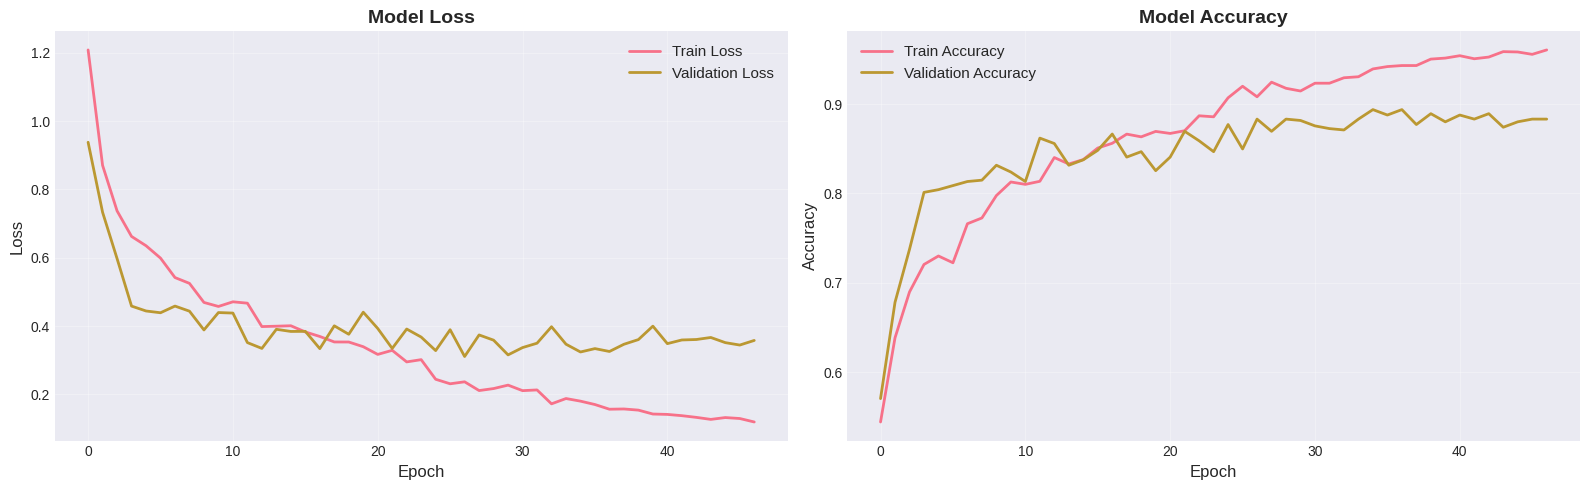


최고 검증 정확도: 0.8938 (Epoch 35)
최종 학습 정확도: 0.9605
최종 검증 정확도: 0.8832


In [17]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss 곡선
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy 곡선
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# 최고 성능 출력
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n최고 검증 정확도: {history.history['val_accuracy'][best_epoch]:.4f} (Epoch {best_epoch + 1})")
print(f"최종 학습 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")

## 8. 모델 평가

In [18]:
# 테스트 데이터로 예측
print("테스트 데이터 평가 중...\n")

# 확률 예측
y_pred_prob = model.predict(X_test, verbose=0)

# 클래스 예측
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"테스트 정확도: {accuracy:.4f}")
print(f"가중 F1-Score: {f1:.4f}")

테스트 데이터 평가 중...

테스트 정확도: 0.8689
가중 F1-Score: 0.8673


In [19]:
# Classification Report
print("\n" + "="*60)
print("Classification Report")
print("="*60)
target_names = [f'Fault Type {i}' for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


Classification Report
              precision    recall  f1-score   support

Fault Type 0     0.9066    0.9499    0.9277       419
Fault Type 1     0.7895    0.7500    0.7692       200
Fault Type 2     0.8304    0.7750    0.8017       120
Fault Type 3     0.9036    0.8824    0.8929        85

    accuracy                         0.8689       824
   macro avg     0.8575    0.8393    0.8479       824
weighted avg     0.8668    0.8689    0.8673       824



### 8.1 Confusion Matrix 시각화

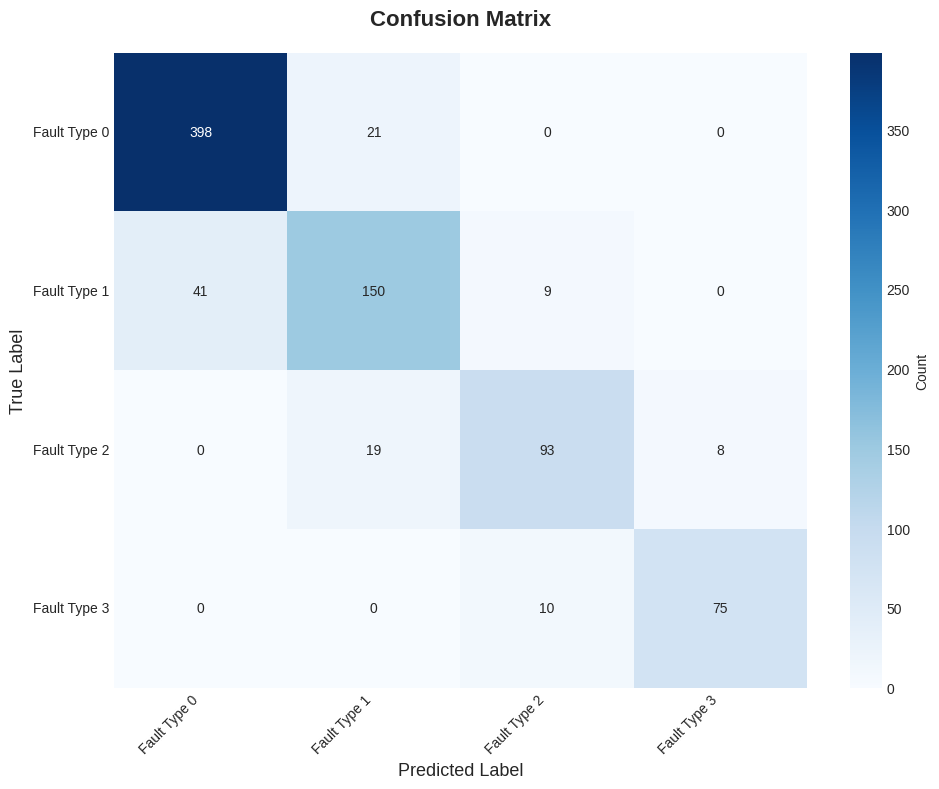

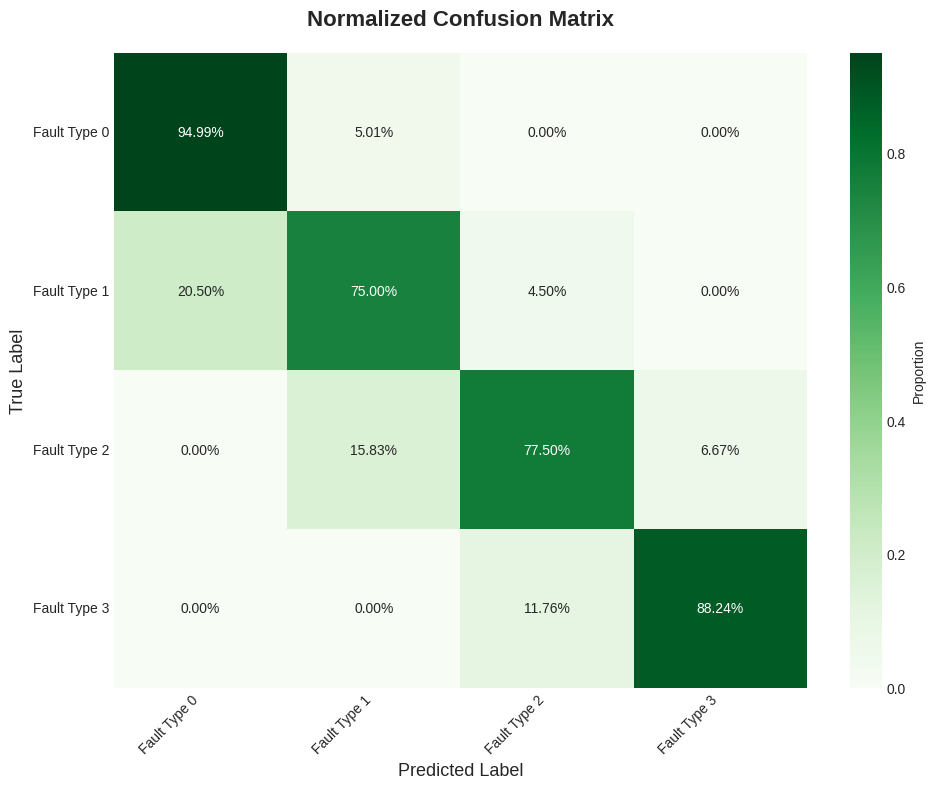

In [20]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 정규화된 Confusion Matrix (비율)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.2 클래스별 성능 시각화


클래스별 성능 지표:
       Class  Precision   Recall  F1-Score  Support
Fault Type 0   0.906606 0.949881  0.927739      419
Fault Type 1   0.789474 0.750000  0.769231      200
Fault Type 2   0.830357 0.775000  0.801724      120
Fault Type 3   0.903614 0.882353  0.892857       85


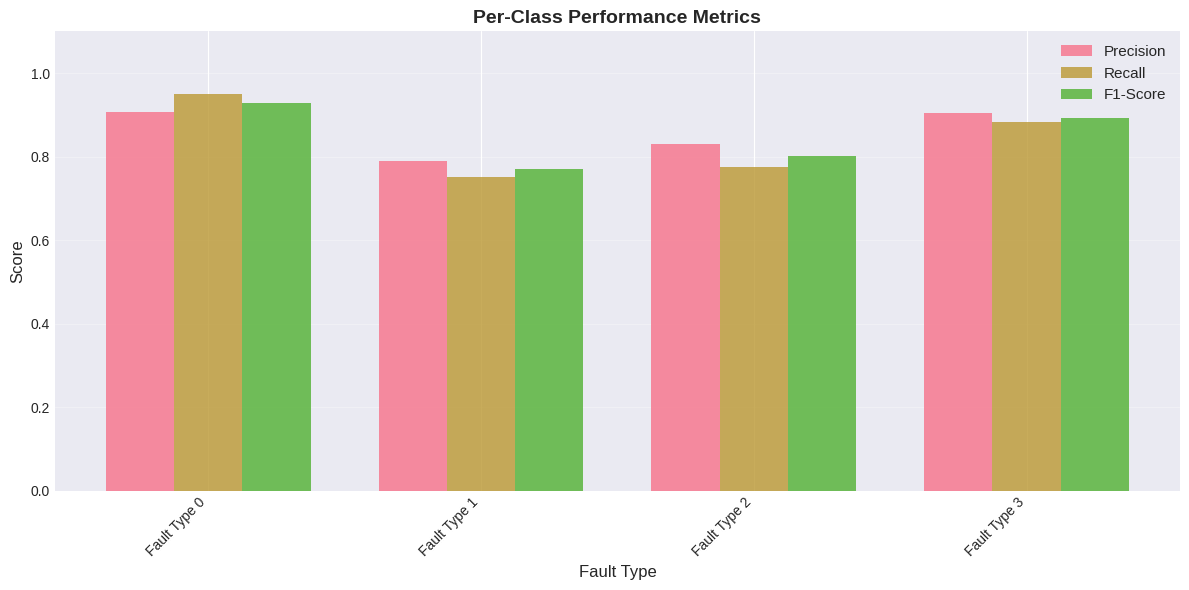

In [21]:
# 클래스별 Precision, Recall, F1-Score 시각화
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_scores, support = precision_recall_fscore_support(y_true, y_pred)

# 데이터프레임 생성
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_scores,
    'Support': support
})

print("\n클래스별 성능 지표:")
print(metrics_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(target_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Fault Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('../models/class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.3 예측 확률 분포 분석

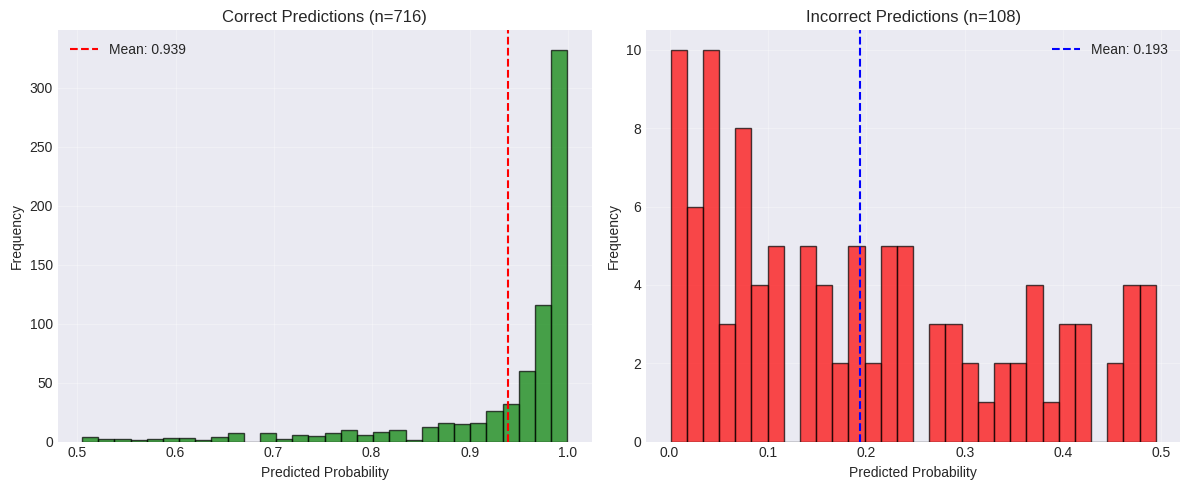


올바른 예측의 평균 확률: 0.9392
잘못된 예측의 평균 확률: 0.1934


In [22]:
# 예측 확률 분포 시각화 (올바른 예측 vs 잘못된 예측)
correct_mask = (y_true == y_pred)
correct_probs = y_pred_prob[correct_mask][np.arange(np.sum(correct_mask)), y_true[correct_mask]]
incorrect_probs = y_pred_prob[~correct_mask][np.arange(np.sum(~correct_mask)), y_true[~correct_mask]]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title(f'Correct Predictions (n={len(correct_probs)})')
plt.axvline(correct_probs.mean(), color='red', linestyle='--', 
           label=f'Mean: {correct_probs.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title(f'Incorrect Predictions (n={len(incorrect_probs)})')
if len(incorrect_probs) > 0:
    plt.axvline(incorrect_probs.mean(), color='blue', linestyle='--',
               label=f'Mean: {incorrect_probs.mean():.3f}')
    plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/prediction_probabilities.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n올바른 예측의 평균 확률: {correct_probs.mean():.4f}")
if len(incorrect_probs) > 0:
    print(f"잘못된 예측의 평균 확률: {incorrect_probs.mean():.4f}")

## 9. 예측 예시 분석

In [23]:
# 랜덤 샘플 예측 분석
n_samples_to_show = 5
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

print("\n" + "="*80)
print("예측 샘플 분석")
print("="*80)

for idx in sample_indices:
    true_label = y_true[idx]
    pred_label = y_pred[idx]
    pred_probs = y_pred_prob[idx]
    
    print(f"\n샘플 #{idx}")
    print(f"  실제 클래스: {target_names[true_label]}")
    print(f"  예측 클래스: {target_names[pred_label]}")
    print(f"  예측 확률:")
    for i, (name, prob) in enumerate(zip(target_names, pred_probs)):
        marker = " ← 예측" if i == pred_label else ""
        marker += " (정답)" if i == true_label else ""
        print(f"    {name}: {prob:.4f}{marker}")
    print(f"  결과: {'✓ 정확' if true_label == pred_label else '✗ 오류'}")


예측 샘플 분석

샘플 #610
  실제 클래스: Fault Type 0
  예측 클래스: Fault Type 0
  예측 확률:
    Fault Type 0: 0.9987 ← 예측 (정답)
    Fault Type 1: 0.0008
    Fault Type 2: 0.0002
    Fault Type 3: 0.0002
  결과: ✓ 정확

샘플 #174
  실제 클래스: Fault Type 2
  예측 클래스: Fault Type 2
  예측 확률:
    Fault Type 0: 0.0005
    Fault Type 1: 0.0057
    Fault Type 2: 0.7193 ← 예측 (정답)
    Fault Type 3: 0.2746
  결과: ✓ 정확

샘플 #67
  실제 클래스: Fault Type 0
  예측 클래스: Fault Type 0
  예측 확률:
    Fault Type 0: 0.9657 ← 예측 (정답)
    Fault Type 1: 0.0332
    Fault Type 2: 0.0002
    Fault Type 3: 0.0008
  결과: ✓ 정확

샘플 #168
  실제 클래스: Fault Type 1
  예측 클래스: Fault Type 1
  예측 확률:
    Fault Type 0: 0.0517
    Fault Type 1: 0.9444 ← 예측 (정답)
    Fault Type 2: 0.0036
    Fault Type 3: 0.0003
  결과: ✓ 정확

샘플 #275
  실제 클래스: Fault Type 0
  예측 클래스: Fault Type 0
  예측 확률:
    Fault Type 0: 0.9910 ← 예측 (정답)
    Fault Type 1: 0.0082
    Fault Type 2: 0.0001
    Fault Type 3: 0.0007
  결과: ✓ 정확


## 10. 모델 저장

In [24]:
# 최종 모델 저장
model.save('../models/final_cnn_lstm_model.h5')
print("최종 모델 저장 완료: ../models/final_cnn_lstm_model.h5")

# Scaler 저장 (새로운 데이터 예측 시 필요)
import pickle

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler 저장 완료: ../models/scaler.pkl")

# 모델 설정 저장
config = {
    'window_size': window_size,
    'stride': stride,
    'n_sensors': X_scaled.shape[1],
    'n_classes': n_classes,
    'target_names': target_names
}

with open('../models/model_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("모델 설정 저장 완료: ../models/model_config.pkl")

최종 모델 저장 완료: ../models/final_cnn_lstm_model.h5
Scaler 저장 완료: ../models/scaler.pkl
모델 설정 저장 완료: ../models/model_config.pkl


## 11. 모델 로드 및 사용 예시

In [25]:
# 저장된 모델 로드 예시
def load_saved_model():
    """
    저장된 모델과 관련 설정을 로드
    """
    # 모델 로드
    loaded_model = keras.models.load_model('../models/final_cnn_lstm_model.h5')
    
    # Scaler 로드
    with open('../models/scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    
    # 설정 로드
    with open('../models/model_config.pkl', 'rb') as f:
        loaded_config = pickle.load(f)
    
    return loaded_model, loaded_scaler, loaded_config

# 테스트
print("모델 로드 테스트...")
loaded_model, loaded_scaler, loaded_config = load_saved_model()
print("\n모델 로드 성공!")
print(f"설정: {loaded_config}")

모델 로드 테스트...

모델 로드 성공!
설정: {'window_size': 50, 'stride': 5, 'n_sensors': 21, 'n_classes': 4, 'target_names': ['Fault Type 0', 'Fault Type 1', 'Fault Type 2', 'Fault Type 3']}


## 12. 결론 및 개선 방향

### 달성한 결과
- **실제 PHM 데이터셋** (NASA Turbofan Engine Degradation C-MAPSS) 사용
- CNN-LSTM 하이브리드 모델을 성공적으로 구현
- 슬라이딩 윈도우를 통한 시계열 데이터 처리 및 데이터 증강
- 20,631개 원본 샘플 → 약 4,100개 윈도우 샘플 생성 (stride=5)
- 고장 유형 분류 모델 학습 및 평가

### 데이터셋 특징
- **센서**: 21개 (온도, 압력, 진동 등 항공기 엔진 센서)
- **운영 설정**: 3개 (고도, 속도, 스로틀)
- **엔진**: 100개의 터보팬 엔진
- **고장 분류**: RUL 기반 4단계
  - Type 0: Normal (RUL > 100)
  - Type 1: Early Degradation (50 < RUL ≤ 100)
  - Type 2: Advanced Degradation (20 < RUL ≤ 50)
  - Type 3: Critical (RUL ≤ 20)

### 성능 개선 방법

1. **데이터 증강**
   - Stride 값 조정 (현재 5 → 1~3으로 감소하여 더 많은 샘플)
   - 시계열 증강 기법 (jittering, scaling, time warping)
   - 다른 데이터셋 추가 (FD002, FD003, FD004)

2. **하이퍼파라미터 튜닝**
   - 윈도우 크기 최적화 (30, 50, 100 등 실험)
   - LSTM units 수 조정 (64, 128, 256)
   - Learning rate 스케줄링
   - 배치 크기 조정 (16, 32, 64)

3. **모델 아키텍처 개선**
   - Bidirectional LSTM 사용 (양방향 시계열 패턴)
   - Attention mechanism 추가 (중요 시점 강조)
   - Residual connections (ResNet 스타일)
   - Multi-scale CNN (다양한 kernel size)

4. **앙상블 기법**
   - 여러 모델의 예측을 결합
   - Stacking, Voting, Blending

5. **클래스 불균형 처리**
   - Class weights 조정
   - SMOTE 오버샘플링
   - Focal Loss 사용

6. **다른 PHM 데이터셋 활용**
   - FD002: 6개 운영 조건 (더 복잡한 환경)
   - FD003: 2개 고장 모드 (다양한 고장 패턴)
   - FD004: 6개 운영 조건 + 2개 고장 모드 (최고 난이도)

### 실무 적용 시 고려사항
- **실시간 추론**: 모델 경량화 및 최적화
- **모델 해석**: SHAP, GradCAM을 통한 설명 가능성
- **지속적 학습**: 새로운 데이터로 모델 업데이트 파이프라인
- **엣지 배포**: 항공기 내 실시간 모니터링 시스템
- **비용 분석**: False Positive/Negative의 비즈니스 영향 평가
- **신뢰도 관리**: 예측 confidence 임계값 설정

In [26]:
# 실습 완료 요약 출력
print("\n" + "="*80)
print("실습 완료 요약")
print("="*80)
print(f"데이터셋 크기: {len(df)} 샘플")
print(f"윈도우 개수: {len(X_windows)} 개")
print(f"학습 데이터: {len(X_train)} 개")
print(f"테스트 데이터: {len(X_test)} 개")
print(f"\n최종 테스트 정확도: {accuracy:.4f}")
print(f"최종 가중 F1-Score: {f1:.4f}")
print("\n저장된 파일:")
print("  - ../models/final_cnn_lstm_model.h5")
print("  - ../models/scaler.pkl")
print("  - ../models/model_config.pkl")
print("  - ../models/training_history.png")
print("  - ../models/confusion_matrix.png")
print("\n수고하셨습니다!")
print("="*80)


실습 완료 요약
데이터셋 크기: 20631 샘플
윈도우 개수: 4117 개
학습 데이터: 3293 개
테스트 데이터: 824 개

최종 테스트 정확도: 0.8689
최종 가중 F1-Score: 0.8673

저장된 파일:
  - ../models/final_cnn_lstm_model.h5
  - ../models/scaler.pkl
  - ../models/model_config.pkl
  - ../models/training_history.png
  - ../models/confusion_matrix.png

수고하셨습니다!
